In [4]:
%pip install qiskit qiskit-aer matplotlib pylatexenc

In [5]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from typing import List, Tuple, Set, Optional, Dict

In [6]:
THRESHOLD = 0.90

SHOTS = 1024

# Define winning lines (mapping 3-bit code to list of (row, col) tuples)
WIN_LINES: Dict[str, List[Tuple[int, int]]] = {
    '000': [(0, 0), (0, 1), (0, 2)],  # Row 1 (Index 0)
    '001': [(1, 0), (1, 1), (1, 2)],  # Row 2 (Index 1)
    '010': [(2, 0), (2, 1), (2, 2)],  # Row 3 (Index 2)
    '011': [(0, 0), (1, 0), (2, 0)],  # Column 1 (Index 3)
    '100': [(0, 1), (1, 1), (2, 1)],  # Column 2 (Index 4)
    '101': [(0, 2), (1, 2), (2, 2)],  # Column 3 (Index 5)
    '110': [(0, 0), (1, 1), (2, 2)],  # Diagonal 1 (Index 6)
    '111': [(0, 2), (1, 1), (2, 0)],  # Diagonal 2 (Index 7)
}

WIN_LINES_DESCRIPTIONS = {
    '000': "top row",
    '001': "middle row",
    '010': "bottom row",
    '011': "left column",
    '100': "middle column",
    '101': "right column",
    '110': "diagonal (top-left to bottom-right)",
    '111': "diagonal (top-right to bottom-left)"
}

In [7]:
def cell_bits(square_index: int) -> List[int]:
    """Return qubit indices [q0, q1] for a given 1D square index (0-8)."""
    if not 0 <= square_index <= 8:
        raise ValueError("Square index must be between 0 and 8.")
    return [2 * square_index, 2 * square_index + 1]

In [8]:
def initialize_board(qc: QuantumCircuit, board_reg: QuantumRegister, board_state: List[str]) -> None:
    """
    Initialize the board state in the quantum circuit using 1D list.
    Encoding: |00> = empty (' '), |10> = O, |01> = X
    Qubit state is |q1 q0>
    """
    if len(board_state) != 9:
        raise ValueError("Board state list must have exactly 9 elements.")
    for i, mark in enumerate(board_state):
        q0_idx, q1_idx = cell_bits(i)  # Get indices for cell i
        if mark == "X":  # Player 1: Encode |01>
            qc.x(board_reg[q1_idx])  # Apply X to the second qubit (q1)
        elif mark == "O":  # Player 2: Encode |10>
            qc.x(board_reg[q0_idx])  # Apply X to the first qubit (q0)
        # If mark is ' ', qubits remain in default |00> state

In [9]:
def display_board(board_state: List[str]) -> None:
    """
    Print the current Tic-Tac-Toe board in a formatted grid.
    Displays tile numbers (0-8) for empty squares.
    """

    cells = []
    for i, mark in enumerate(board_state):
        if mark == ' ':
            # If the square is empty (' '), use its index number as a string
            cells.append(str(i))
        else:
            cells.append(mark)

    # Print formatted grid
    print("\n\t+---+---+---+")
    for row in range(3):
        idx = row * 3
        print(f"\t| {cells[idx]} | {cells[idx + 1]} | {cells[idx + 2]} |")
        print("\t+---+---+---+")

In [10]:
def get_valid_input(prompt: str, occupied_tiles: Set[int], valid_range: Tuple[int, int] = (0, 8)) -> int:
    """Prompt for a tile selection, ensuring valid range and unoccupied."""
    while True:
        try:
            value = int(input(prompt))
            if valid_range[0] <= value <= valid_range[1]:
                if value not in occupied_tiles:
                    return value
                else:
                    print(f"  Error: Tile {value} is already occupied. Try again.")
            else:
                print(f"  Error: Input must be between {valid_range[0]} and {valid_range[1]}. Try again.")
        except ValueError:
            print("  Error: Invalid input. Please enter an integer.")

In [11]:
def get_player_move(player_mark: str, occupied_tiles: Set[int]) -> int:
    """
    Prompts the current player for their move (tile selection) and returns
    a validated tile number.
    """
    print(f"\nPlayer {player_mark}'s turn.")
    prompt_message = f"Enter tile number (0-8) for {player_mark}: "
    chosen_tile = get_valid_input(prompt_message, occupied_tiles)
    return chosen_tile

In [12]:
def quantum_check_winner(classical_board_state: List[str], num_shots: int = 1024) -> Tuple[Dict[str, int], QuantumCircuit]:
    """
    Builds the quantum circuit for win checking, executes it, and returns
    both the measurement counts and the QuantumCircuit object itself.
    """
    # 1. Define Registers
    qr_board = QuantumRegister(18, name='board')
    qr_choice = QuantumRegister(3, name='choice')
    qr_win = QuantumRegister(1, name='win')
    cr_choice = ClassicalRegister(3, name='choice_cl')

    # 2. Create Circuit
    qc = QuantumCircuit(qr_board, qr_choice, qr_win, cr_choice, name="QWinCheck")

    # 3. Initialize Board State
    initialize_board(qc, qr_board, classical_board_state)

    # 4. Prepare win qubit and choice register
    qc.x(qr_win[0])
    qc.h(qr_win[0])
    qc.h(qr_choice)
    qc.barrier(label="Setup")

    # 5. Apply Grover Iterations
    num_iterations = 2
    for i in range(num_iterations):
        oracle(qc, qr_board, qr_choice, qr_win, WIN_LINES)
        qc.barrier(label=f"Oracle_{i + 1}")
        diffuser(qc, qr_choice)
        qc.barrier(label=f"Diffuser_{i + 1}")

    # 6. Measure
    qc.measure(qr_choice, cr_choice)

    # 7. Execution
    from qiskit_aer import Aer
    print("Running on AER simulator...")
    aer_simulator = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, aer_simulator)
    job = aer_simulator.run(transpiled_qc, shots=num_shots)
    sim_results = job.result().get_counts()

    # Return both the results and the original (non-transpiled) circuit
    return sim_results, qc

In [13]:
def process_quantum_results(counts: Dict[str, int], classical_board_state: List[str], total_shots: int, threshold: float):
    """Analyzes quantum simulation results to find a winner above a probability threshold."""
    print("Running quantum winner check...")

    if not counts:
        result = "Quantum simulation failed. Cannot determine winner. Exiting."
        return result

    most_probable_line_bits = max(counts, key=counts.get)

    highest_count = counts[most_probable_line_bits]

    win_probability = highest_count / total_shots

    if win_probability < threshold:
        return None

    cells_to_check = WIN_LINES[most_probable_line_bits]

    first_cell_coords = cells_to_check[0]

    first_cell_index = first_cell_coords[0] * 3 + first_cell_coords[1]

    mark_on_line = classical_board_state[first_cell_index]

    line_desc = WIN_LINES_DESCRIPTIONS.get(most_probable_line_bits, f"line {most_probable_line_bits}")

    result = f"Player {mark_on_line} wins on {line_desc} with probability: {win_probability:.2f}!"

    return result

In [14]:
def oracle(qc: QuantumCircuit, board_reg: QuantumRegister, choice_reg: QuantumRegister, win_reg: QuantumRegister,
           win_lines: Dict[str, List[Tuple[int, int]]]) -> None:
    """Oracle using phase kickback."""
    for code, cells in win_lines.items():
        # --- Prepare Choice Controls ---
        choice_controls = []
        temp_choice_flips = []
        for idx, bit in enumerate(reversed(code)):
            q_index = idx
            if bit == '0':
                qc.x(choice_reg[q_index])
                temp_choice_flips.append(choice_reg[q_index])
            choice_controls.append(choice_reg[q_index])

        # --- Check for X win ---
        x_win_check_controls = choice_controls.copy()
        temp_flips_x = []
        for (row, col) in cells:
            square_index = row * 3 + col
            q0_idx, q1_idx = cell_bits(square_index)
            qc.x(board_reg[q0_idx])
            temp_flips_x.append(board_reg[q0_idx])
            x_win_check_controls.append(board_reg[q0_idx])
            x_win_check_controls.append(board_reg[q1_idx])

        # Apply MCX for X win check using phase kickback
        qc.mcx(x_win_check_controls, win_reg[0])

        # Undo temporary flips for X check
        for qubit in reversed(temp_flips_x):
            qc.x(qubit)

        # --- Check for O win ---
        o_win_check_controls = choice_controls.copy()
        temp_flips_o = []
        for (row, col) in cells:
            square_index = row * 3 + col
            q0_idx, q1_idx = cell_bits(square_index)
            qc.x(board_reg[q1_idx])
            temp_flips_o.append(board_reg[q1_idx])
            o_win_check_controls.append(board_reg[q0_idx])
            o_win_check_controls.append(board_reg[q1_idx])

        # Apply MCX for O win check using the same win qubit
        qc.mcx(o_win_check_controls, win_reg[0])

        # Undo temporary flips for O check
        for qubit in reversed(temp_flips_o):
            qc.x(qubit)

        # Undo Choice Controls
        for qubit in reversed(temp_choice_flips):
            qc.x(qubit)

In [15]:
def diffuser(circuit: QuantumCircuit, qubits: QuantumRegister) -> None:
    """Apply diffuser (inversion about the mean) to qubits."""
    n = len(qubits)
    if n == 0: return  # Nothing to do
    circuit.h(qubits)
    circuit.x(qubits)
    # Apply multi-controlled Z gate (or equivalent using MCX with phase kickback)
    if n > 1:
        circuit.h(qubits[-1])  # Use last qubit as target for MCX
        # Apply MCX with all other qubits as controls
        circuit.mcx(qubits[:-1], qubits[-1])
        circuit.h(qubits[-1])  # Uncompute H on target
    elif n == 1:  # Single qubit Z gate
        circuit.z(qubits[0])
    circuit.x(qubits)
    circuit.h(qubits)

In [16]:
def play_game() -> None:
    """Run interactive Quantum Tic-Tac-Toe with turn-by-turn quantum winner check."""

    # Initialize classical board state (' ', 'X', 'O')
    classical_board_state = [" " for _ in range(9)]
    occupied_tiles = set()  # Keep track of used tile indices (0-8)

    current_player = 1  # Player 1 starts
    turn_counter = 0  # Track turns for file names etc.
    game_not_over = True

    # Gameplay Loop
    while game_not_over:
        turn_counter += 1

        print("\n-------------------------------------")
        print(f"\nCurrent Classical Board State (Turn {turn_counter}):")

        display_board(classical_board_state)

        player_mark = "X" if current_player == 1 else "O"

        selected_tile = get_player_move(player_mark, occupied_tiles)
        classical_board_state[selected_tile] = player_mark
        occupied_tiles.add(selected_tile)

        if turn_counter < 5:
            current_player = 2 if current_player == 1 else 1
            continue

        counts_from_sim, current_circuit = quantum_check_winner(classical_board_state, num_shots=SHOTS)

        last_counts = counts_from_sim
        last_quantum_circuit = current_circuit

        result = process_quantum_results(counts_from_sim, classical_board_state, SHOTS, THRESHOLD)

        if result:
            break

        if turn_counter == 9:
            result = "Draw! All tiles filled, no winner detected."
            break

        current_player = 2 if current_player == 1 else 1

    print("Game Over.\n")
    print(result)
    print("\nFinal classical board state was:")
    display_board(classical_board_state)
    print("\n")

    if last_counts and last_quantum_circuit:
        display(plot_histogram(last_counts, title="Win Line Counts"))
        print("\nHistogram Key")
        for code, description in WIN_LINES_DESCRIPTIONS.items():
            print(f"{code}: {description}")
        print("\n")
        display(last_quantum_circuit.draw('mpl', fold=-1))


-------------------------------------

Current Classical Board State (Turn 1):

	+---+---+---+
	| 0 | 1 | 2 |
	+---+---+---+
	| 3 | 4 | 5 |
	+---+---+---+
	| 6 | 7 | 8 |
	+---+---+---+

Player X's turn.
Enter tile number (0-8) for X: 0

-------------------------------------

Current Classical Board State (Turn 2):

	+---+---+---+
	| X | 1 | 2 |
	+---+---+---+
	| 3 | 4 | 5 |
	+---+---+---+
	| 6 | 7 | 8 |
	+---+---+---+

Player O's turn.
Enter tile number (0-8) for O: 18
  Error: Input must be between 0 and 8. Try again.
Enter tile number (0-8) for O: 8

-------------------------------------

Current Classical Board State (Turn 3):

	+---+---+---+
	| X | 1 | 2 |
	+---+---+---+
	| 3 | 4 | 5 |
	+---+---+---+
	| 6 | 7 | O |
	+---+---+---+

Player X's turn.
Enter tile number (0-8) for X: 3

-------------------------------------

Current Classical Board State (Turn 4):

	+---+---+---+
	| X | 1 | 2 |
	+---+---+---+
	| X | 4 | 5 |
	+---+---+---+
	| 6 | 7 | O |
	+---+---+---+

Player O's turn.


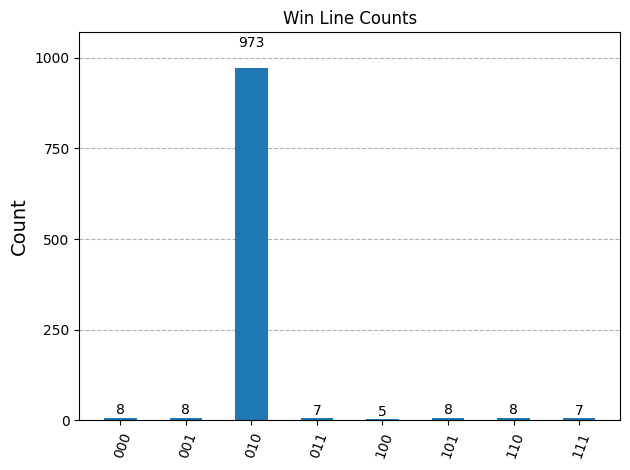


Histogram Key
000: top row
001: middle row
010: bottom row
011: left column
100: middle column
101: right column
110: diagonal (top-left to bottom-right)
111: diagonal (top-right to bottom-left)




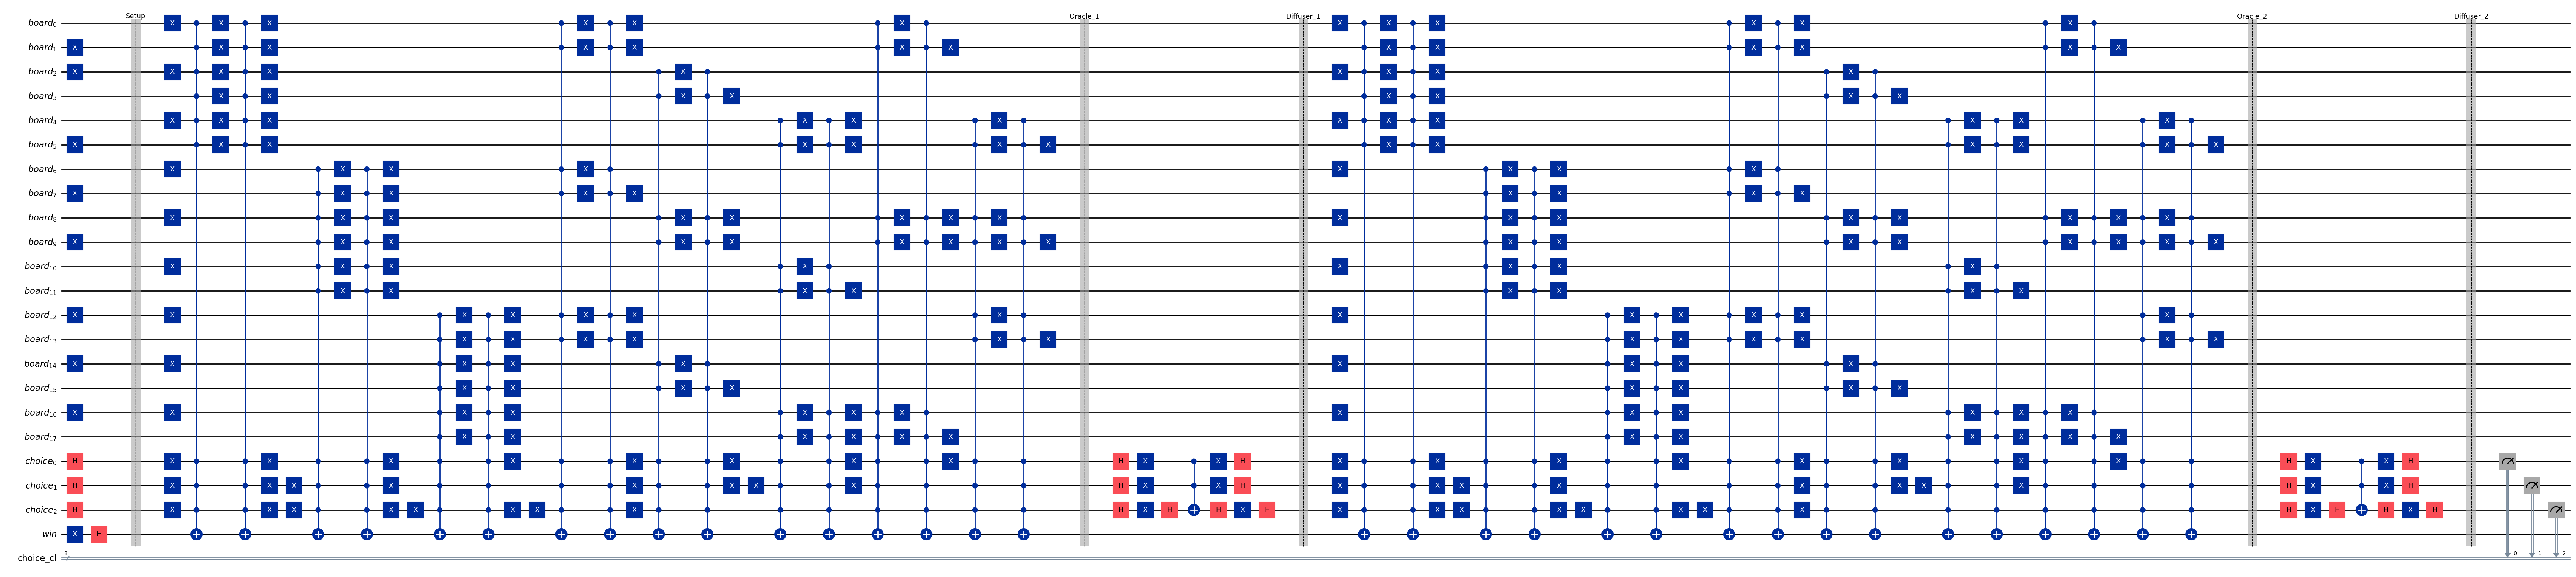

In [17]:
try:
    play_game()
except KeyboardInterrupt:
    print("Game interrupted by user. Exiting...")